In [1]:
# NN packages
import jax
import jax.numpy as jnp
import optax

# Visualization packages
import matplotlib.pyplot as plt

# ML Models
from models.MDOF_LNN import Physical_Damped_LNN_V2, Modal_MLP

# Helper functions
from helpers import save_to_file, create_modal_training_data, plot_S_curves, plot_3DS_curves

#### Data Extraction
In this section, we extract the `pose`, `velocity`, `acceleration`, `time`, `force amplitude` and `period` from each continuation simulation file. This dataset was created for **frequencies** ranging from $10.0Hz$ to $24.0Hz$ in steps of $0.2Hz$, where for each, the continuation parameter was the **forcing amplitude**.

The output is in **modal coordinates**.

In [2]:
filename='frequency_step_frequency_'
path='results/modal'
start=10.0
stop=24.0
step=0.2

ml_data = save_to_file(filename=filename, path=path, start=start, stop=stop, step=step, check=True)

Data saved to results/modal/data.pkl
Number of files: 71

---EXAMPLE SHAPES---
pose: (2, 301, 39), vel: (2, 301, 39), acc: (2, 301, 39)
If MODAL: 2 Modes, 301 time steps per 39 points along curve
If PHYSICAL: 301 time steps per 39 points along curve
time: (301, 39), F: (39,), T: (39,), force: (2, 301, 39)


#### LNN Dataset Formation

In [3]:
train_data, test_data, info = create_modal_training_data(ml_data, path, split=0.2, seed=42)

Training data shape: (805175, 2, 4), Testing data shape: (207389, 2, 4)
Samples, # of Modes, [x, dx, ddx, force]
x_train.shape: (805175, 2), dx_train.shape: (805175, 2), ddx_train.shape: (805175, 2), force_train.shape: (805175, 2)
x_test.shape: (207389, 2), dx_test.shape: (207389, 2), ddx_test.shape: (207389, 2), force_test.shape: (207389, 2)


In [4]:
# Format dataset for LNN
# Position, velocity & total forcing conditions
train_x = train_data[:, :, :2]
train_dx = train_data[:, :, 1:3]
train_f = train_data[:, :, 3:]

test_x = test_data[:, :, :2]
test_dx = test_data[:, :, 1:3]
test_f = test_data[:, :, 3:]

train_data = train_x, train_f, train_dx
test_data = test_x, test_f, test_dx

In [5]:
train_data[0].shape, test_data[0].shape, train_data[1].shape, test_data[1].shape, train_data[2].shape, test_data[2].shape

((805175, 2, 2),
 (207389, 2, 2),
 (805175, 2, 1),
 (207389, 2, 1),
 (805175, 2, 2),
 (207389, 2, 2))

#### LNN


In [6]:
mnn_settings = {
    'name': 'MNN',
    'units': 64,
    'layers': 4,
    'input_shape': 4,
    'train_batch_size': 128,
    'test_batch_size': 16,
    'shuffle': True,
    'seed': 69
    }

knn_settings = {
    'name': 'KNN',
    'units': 64,
    'layers': 4,
    'input_shape': 4,
    }

dnn_settings = {
    'name': 'DNN',
    'units': 32,
    'layers': 4,
    'input_shape': 2,
    }

results_path = 'MDOF_LNN'
file_name='Phys'

lr = 1e-03
mnn_optimizer = optax.adam(lr)
knn_optimizer = optax.adam(lr)
dnn_optimizer = optax.adam(lr)
epochs = 20
show_every = 10

In [7]:
a = Physical_Damped_LNN_V2(
    mnn_module=Modal_MLP, 
    knn_module=Modal_MLP,       
    dnn_module=Modal_MLP, 
    mnn_settings=mnn_settings,
    knn_settings=knn_settings,
    dnn_settings=dnn_settings, 
    mnn_optimizer=mnn_optimizer, 
    knn_optimizer=knn_optimizer, 
    dnn_optimizer=dnn_optimizer, 
    info=info, 
    activation=jax.nn.tanh)

# Start training LNN
results = None
_, _, _ = a.gather()

In [8]:
results_path = 'MDOF_LNN'
file_name='Modal'

epochs = 20
show_every = 10

In [9]:
# Standard loss
for _ in range(10):
    results = a.train(train_data, test_data, results, epochs=epochs, show_every=show_every)
    a.save_model(results, model_name=f"Iter_{results['last_epoch']}", folder_name=f"{results_path}/{file_name}")
print(f"Final loss: {results['best_loss']}")

Epoch: 0 | Train Loss: 16767.10937500 | Best Loss: 3233.27319336 | Test Loss: 3233.27319336
---------------------------------
Epoch: 10 | Train Loss: 0.00560433 | Best Loss: 0.03204907 | Test Loss: 0.03204907
---------------------------------
Epoch: 20 | Train Loss: 0.00003700 | Best Loss: 0.00003183 | Test Loss: 0.00006008
---------------------------------
Epoch: 30 | Train Loss: 0.00001774 | Best Loss: 0.00001996 | Test Loss: 0.00002244
---------------------------------
Epoch: 40 | Train Loss: 0.00001454 | Best Loss: 0.00001571 | Test Loss: 0.00010818
---------------------------------
Epoch: 50 | Train Loss: 0.00002793 | Best Loss: 0.00000869 | Test Loss: 0.00001062
---------------------------------
Epoch: 60 | Train Loss: 0.00001581 | Best Loss: 0.00000452 | Test Loss: 0.00015924
---------------------------------
Epoch: 70 | Train Loss: 0.00001388 | Best Loss: 0.00000452 | Test Loss: 0.00002630
---------------------------------
Epoch: 80 | Train Loss: 0.00000942 | Best Loss: 0.00000

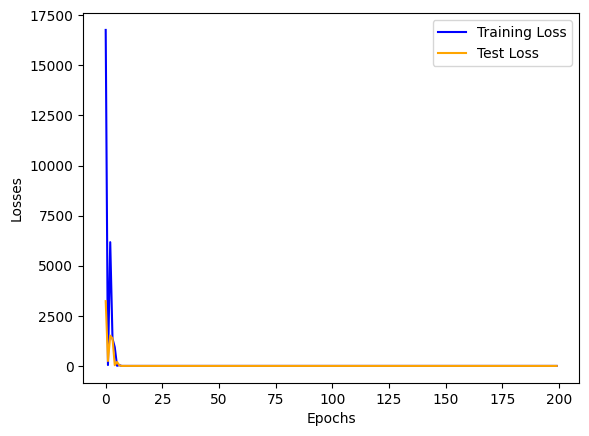

In [14]:
a.plot_results(results)

In [15]:
pred_acc_, pred_energy = a._predict(results)

In [11]:
limq11, limq12, limqd11, limqd12 = info["q1min"], info["q1max"], info["qd1max"], info["qd1min"]
limq21, limq22, limqd21, limqd22 = info["q2min"], info["q2max"], info["qd2max"], info["qd2min"]

q1a, q1da = jnp.linspace(limq11, limq12, 100), jnp.linspace(
    limqd11, limqd12, 100)
q1aa, q1daa = jnp.meshgrid(q1a, q1da)

q2a, q2da = jnp.linspace(limq21, limq22, 100), jnp.linspace(
    limqd21, limqd22, 100)
q2aa, q2daa = jnp.meshgrid(q2a, q2da)

q1a.shape, q1da.shape, q1aa.shape, q1daa.shape, q2a.shape, q2da.shape, q2aa.shape, q2daa.shape

((100,),
 (100,),
 (100, 100),
 (100, 100),
 (100,),
 (100,),
 (100, 100),
 (100, 100))

In [12]:
M, K, C = jax.vmap(pred_energy)(jnp.concatenate([q1aa.reshape(-1, 1), q2aa.reshape(-1, 1)], axis=1), jnp.concatenate([q1daa.reshape(-1, 1), q2daa.reshape(-1, 1)], axis=1))

L = M - K
M.shape, K.shape, C.shape, L.shape

((10000, 2), (10000, 2), (10000, 2), (10000, 2))

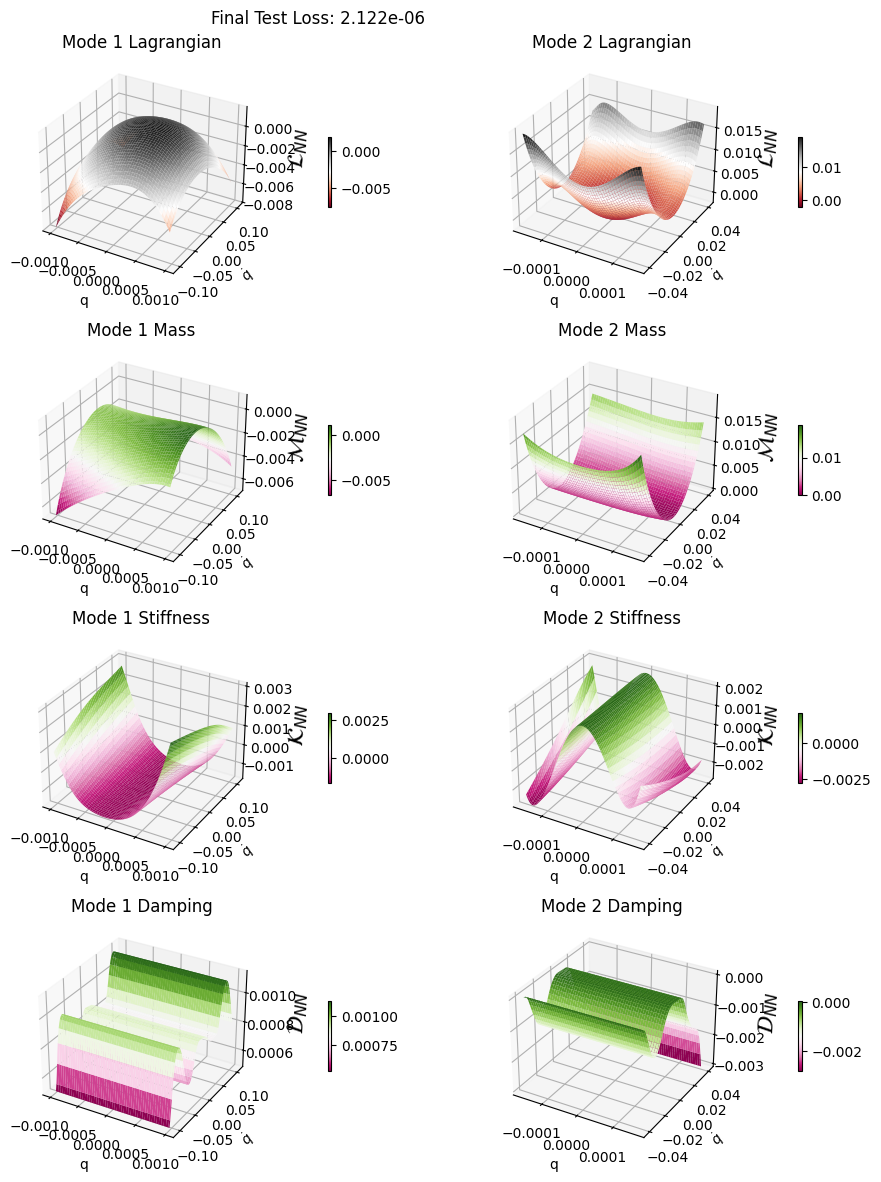

In [13]:
fig = plt.figure(figsize=(12, 12), tight_layout=True)
fig.suptitle(f"Final Test Loss: {results['best_loss']:.3e}")

# --------------------------------- FUNCTIONS

# -------------------------------- Lagrangian
ax = fig.add_subplot(421, projection="3d")
m = ax.plot_surface(q1aa, q1daa, L[:, 0].reshape(q1aa.shape), cmap="RdGy", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
ax.set_title(f"Mode 1 Lagrangian")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(422, projection="3d")
m = ax.plot_surface(q2aa, q2daa, L[:, 1].reshape(q2aa.shape), cmap="RdGy", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
ax.set_title(f"Mode 2 Lagrangian")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Mass
ax = fig.add_subplot(423, projection="3d")
m = ax.plot_surface(q1aa, q1daa, M[:, 0].reshape(q1aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Mass")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(424, projection="3d")
m = ax.plot_surface(q2aa, q2daa, M[:, 1].reshape(q2aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Mass")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Stiffness
ax = fig.add_subplot(425, projection="3d")
m = ax.plot_surface(q1aa, q1daa, K[:, 0].reshape(q1aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Stiffness")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(426, projection="3d")
m = ax.plot_surface(q2aa, q2daa, K[:, 1].reshape(q2aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Stiffness")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Damping
ax = fig.add_subplot(427, projection="3d")
m = ax.plot_surface(q1aa, q1daa, C[:, 0].reshape(q1aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Damping")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(428, projection="3d")
m = ax.plot_surface(q2aa, q2daa, C[:, 1].reshape(q2aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Damping")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)
# fig.savefig(f"./Modal_LNN/{file_name}-LD.png")


In [21]:
ddx = pred_acc_(test_x, test_f)
ddx.shape, test_dx.shape

((207389, 2), (207389, 2, 2))

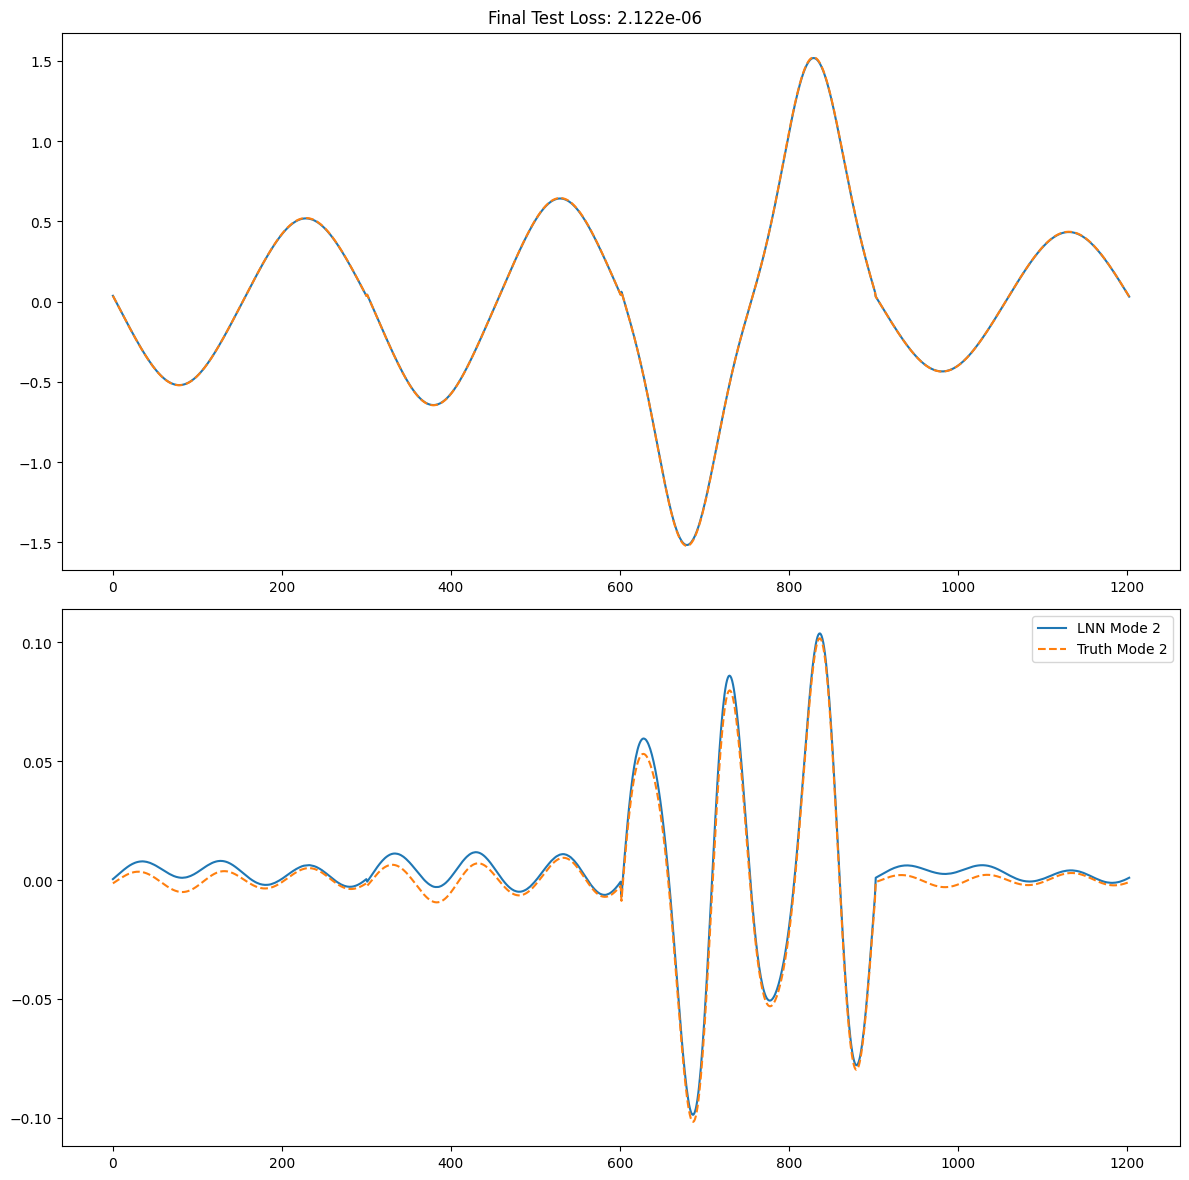

In [42]:
fig = plt.figure(figsize=(12, 12), tight_layout=True)
fig.suptitle(f"Final Test Loss: {results['best_loss']:.3e}")

ax = fig.add_subplot(211)
ax.plot(ddx[:301*4, 0], label="LNN Mode 1")
ax.plot(test_dx[:301*4, 0, -1], label="Truth Mode 1", linestyle='dashed')

ax = fig.add_subplot(212)
ax.plot(ddx[:301*4, 1], label="LNN Mode 2")
ax.plot(test_dx[:301*4, 1, -1], label="Truth Mode 2", linestyle='dashed')

plt.legend()

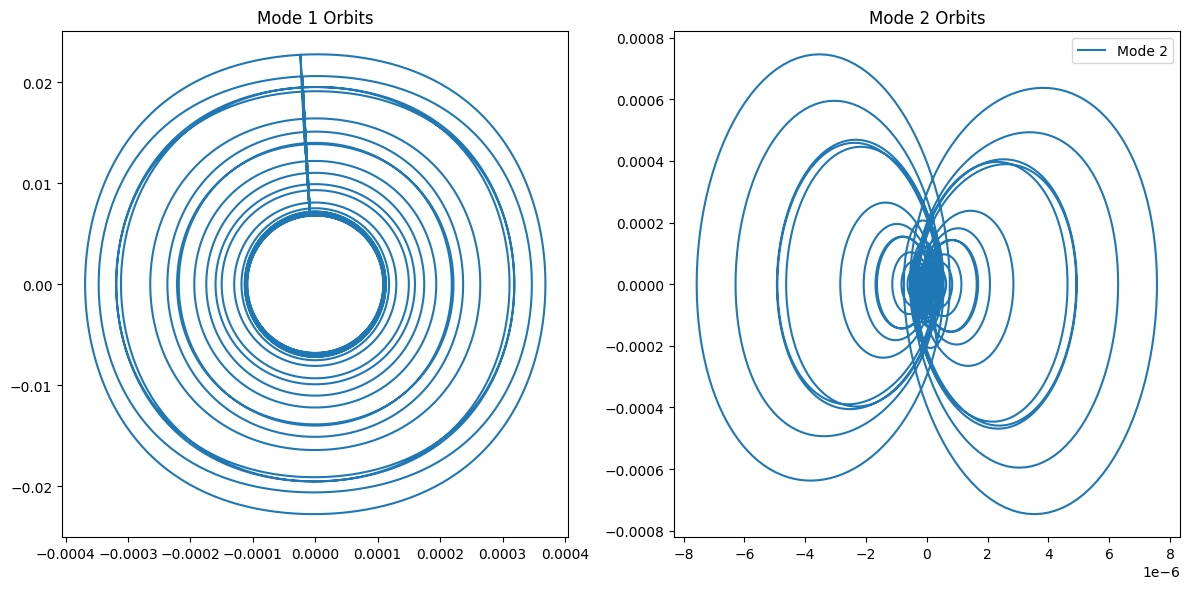

In [40]:
fig = plt.figure(figsize=(12, 6), tight_layout=True)

ax = fig.add_subplot(121)
ax.plot(test_x[:301*20, 0, 0], test_x[:301*20, 0, 1], label="Mode 1")
ax.set_title("Mode 1 Orbits")

ax = fig.add_subplot(122)
ax.plot(test_x[:301*20, 1, 0], test_x[:301*20, 1, 1], label="Mode 2")
ax.set_title("Mode 2 Orbits")

plt.legend()